# Part 1

## Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [1]:
# Import the libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from collections import Counter
import warnings

Firstly we are going to read the json file and convert it to a data frame to easier reading.

In [2]:
# Read the data
with open('logins.json') as json_file:
    json_data = json.load(json_file)

We only have the time the user logged in.

In [4]:
#Conver the json data to a data frame using pd.DataFrame
df = pd.DataFrame(json_data)
df['login_time'] = pd.to_datetime(df['login_time'])
# Start to count the logins
df['Count'] = 1
df.set_index('login_time', inplace = True)

In [5]:
#See how the data frame looks like
df.head()

,Count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
# Resample the index each 15 minutes
df_resample = df.resample('15Min').sum()

In [7]:
# See the resampled data
df_resample.head()

,Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


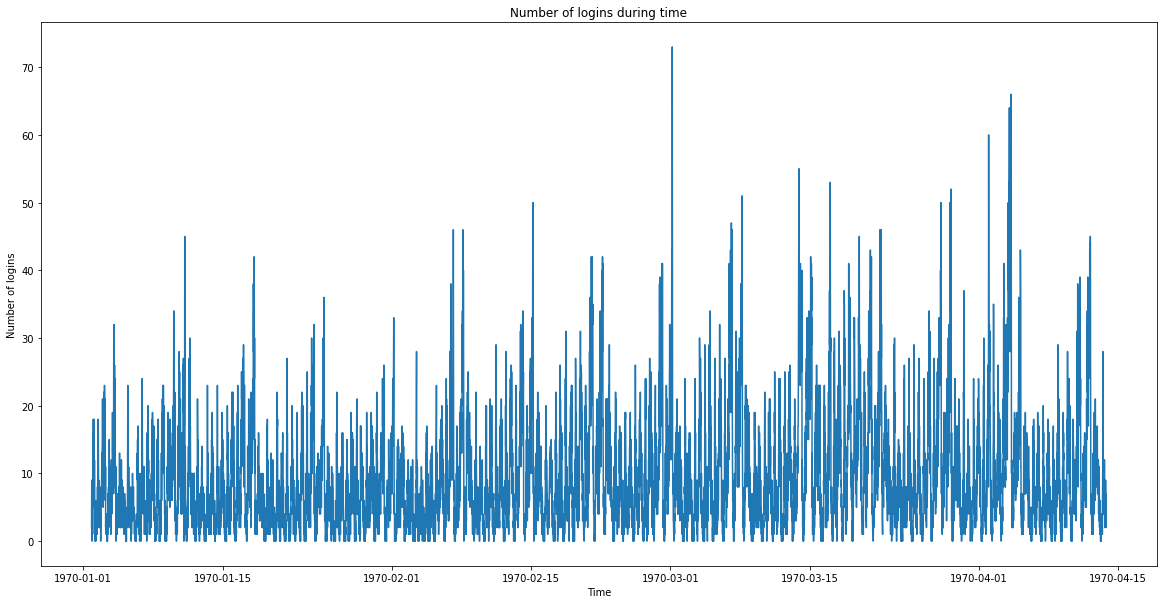

In [8]:
# Plot the resampled data to see general patterns
plt.figure(figsize=(20,10))
warnings.simplefilter('ignore')
plt.plot(df_resample)
plt.xlabel('Time')
plt.ylabel('Number of logins')
plt.title('Number of logins during time')
plt.show()

#### From the data frame we can see some patterns. One is that during 1970-03-15 occurred the higher number of loggins. Besides, it started with not so many logings, then an increase and then went down again. Though, it had a very stable behavior.

### Now we want to analyze the difference between the business days and weekends

In [9]:
#Resample daily
df_logins = df_resample.resample('D').sum()

#Create an index of just the date portion of your index 
df_days = pd.to_datetime(df_logins.index.date)

#Create a range of business days over that period
bdays = pd.bdate_range(start=df_logins.index[0].date(), end=df_logins.index[-1].date())

#Filter the series to just those days contained in the business day range and weekends
df_bdays = df_logins[df_days.isin(bdays)]
df_weekend = df_logins[~df_days.isin(bdays)]

In [10]:
# See the data frame
df_bdays.head()

,Count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-05,459
1970-01-06,536
1970-01-07,648


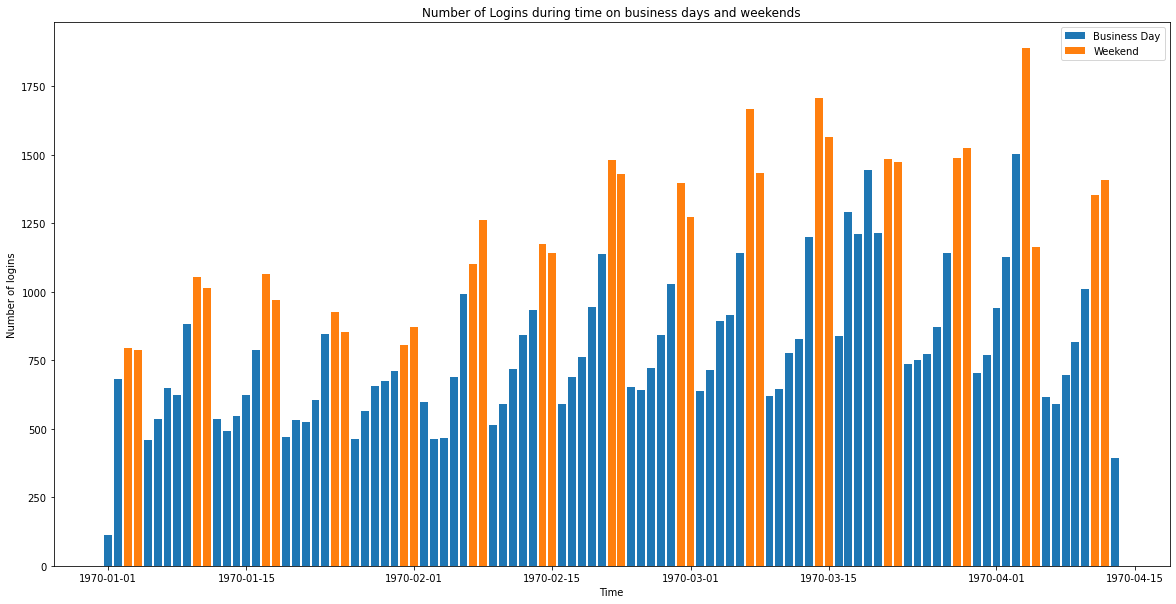

In [11]:
#Plot in different colors the number of logins on business days and weekends
plt.figure(figsize = (20,10))
plt.bar(x = df_bdays.index, height = df_bdays['Count'], label = 'Business Day')
plt.bar(x = df_weekend.index, height = df_weekend['Count'], label = 'Weekend')
plt.xlabel('Time')
plt.ylabel('Number of logins')
plt.title('Number of Logins during time on business days and weekends')
plt.legend(loc = 'best')
plt.show()

#### We see a trend that weekends is the trend of having higher number of loggins. It is also a very stable behavior where Monday is when the number of logins is the lowest, and Saturday and Sunday have very similar number of logins. 

### Analyze hour and day of the week

In [12]:
# Make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(df.index.dayofweek)
#Create new data frame
df2 = pd.DataFrame()
df2['Login_time'] = df.index
df2['Login_time'] = pd.to_datetime(df2['Login_time'], format = '%Y-%m-%d %s')
df2['Day of the week'] = day_of_week
df2['Day of the week'] = df2['Day of the week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 
                                                            3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'})
df2['Count'] = 1
#Change index
df2.set_index('Login_time', inplace = True)

In [13]:
# Add a column with the hour
df2['Hour'] = [time.hour for time in df2.index]  
df2.head()

,Day of the week,Count,Hour
Login_time,,,
1970-01-01 20:13:18,Thursday,1,20
1970-01-01 20:16:10,Thursday,1,20
1970-01-01 20:16:37,Thursday,1,20
1970-01-01 20:16:36,Thursday,1,20
1970-01-01 20:26:21,Thursday,1,20


In [14]:
#Create a pivot table to graphic this in a better way (Variables hour, day of the week and number of logins)
df_pivot = df2.pivot_table(values = 'Count', index = 'Hour',columns = 'Day of the week', aggfunc = 'sum')

In [15]:
# See how the data frame looks like
df_pivot.head()

Day of the week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Hour,,,,,,,
0,975,531,1254,1123,816,607,687
1,957,414,1562,1355,777,566,686
2,771,312,1608,1608,625,394,482
3,502,236,1574,1647,375,198,299
4,353,206,1719,2107,255,149,245


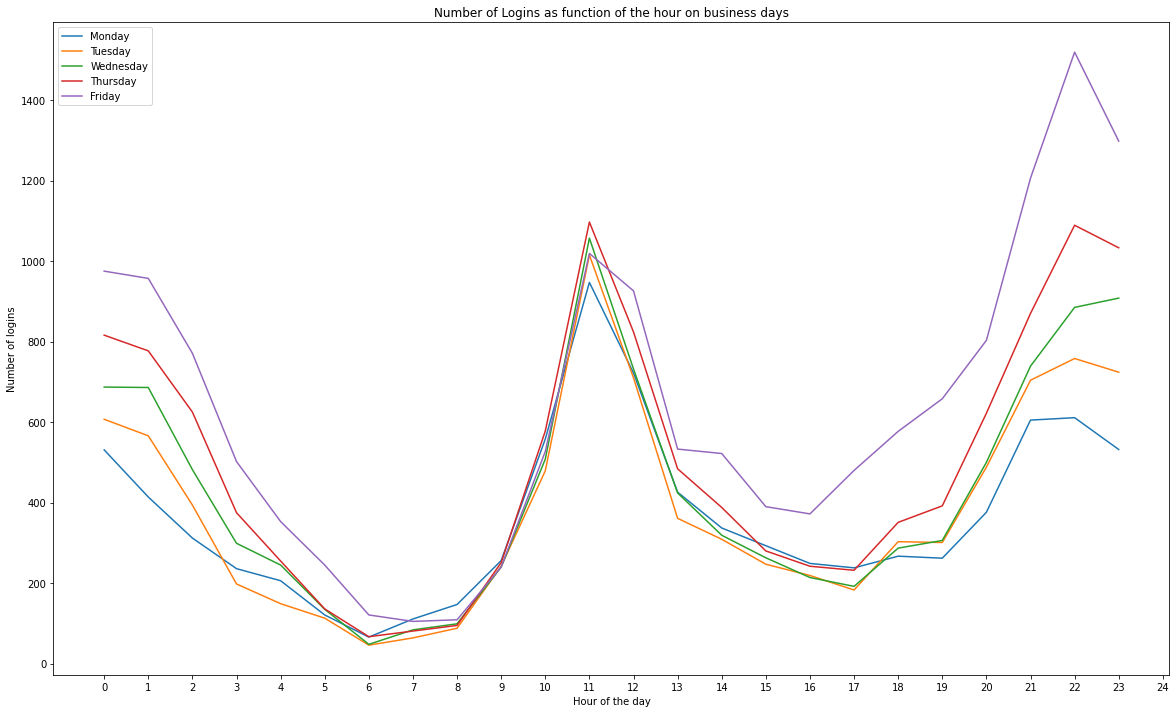

In [16]:
#Make the graphics for business days
plt.figure(figsize = (20,12))
plt.plot(df_pivot.index, df_pivot['Monday'], label = 'Monday')
plt.plot(df_pivot.index, df_pivot['Tuesday'], label = 'Tuesday')
plt.plot(df_pivot.index, df_pivot['Wednesday'], label = 'Wednesday')
plt.plot(df_pivot.index, df_pivot['Thursday'], label = 'Thursday')
plt.plot(df_pivot.index, df_pivot['Friday'], label = 'Friday')
plt.xlabel('Hour of the day')
plt.ylabel('Number of logins')
plt.title('Number of Logins as function of the hour on business days')
plt.xticks(np.arange(0,25))
plt.legend(loc = 'best')
plt.show()

#### The behavior is incredibly similar. They follow almost exactly the same trend, with the addition that Friday had most logins, so in high occurency hours, they have higher number of logins. The worst hours are between 2 and 8 probably because people are sleeping and the top is during noon, and midnght.

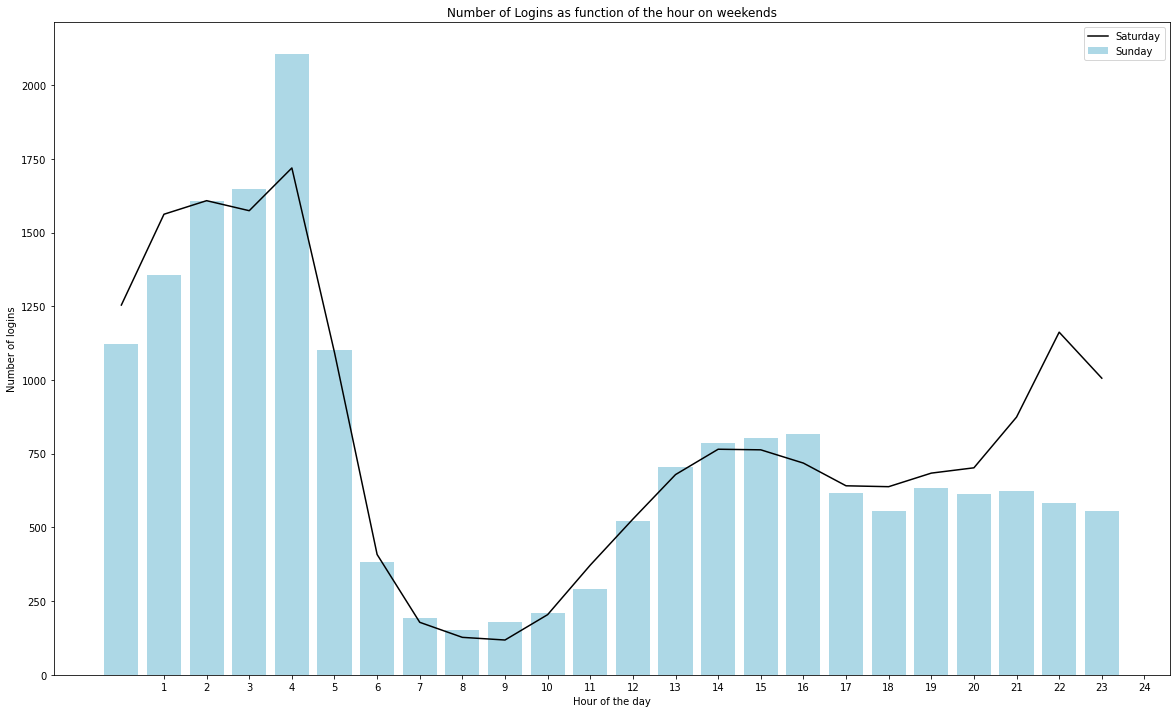

In [17]:
plt.figure(figsize = (20,12))
plt.plot(df_pivot.index, df_pivot['Saturday'], label = 'Saturday', color = 'black')
plt.bar(df_pivot.index, df_pivot['Sunday'], label = 'Sunday', color = 'lightblue')
plt.xlabel('Hour of the day')
plt.ylabel('Number of logins')
plt.title('Number of Logins as function of the hour on weekends')
plt.legend(loc = 'best')
plt.xticks(np.arange(1,25))
plt.show()

#### On weekends. the hours with more occurrencies are at 5 am which is interesting. They either wake up early or during weekends they go to bed late, so they do all of their activities at 5 am. 

#### As final insight, weekends and weekdays have a avery different behavior regarding trends.

### Months behavior

In [18]:
# Make a list of the months
month_of_year = list(df.index.month)
#Create new data frame
df3 = pd.DataFrame()
df3['Login_time'] = df.index
df3['Login_time'] = pd.to_datetime(df3['Login_time'], format = '%Y-%m-%d %s')
df3['Month'] = month_of_year

df3['Count'] = 1
#Change index
df3.set_index('Login_time', inplace = True)

In [19]:
# Group by and aggreate function to see the number of logins per month
df3_grouped = df3.groupby('Month').agg('sum')
df3_grouped.head()

,Count
Month,
1,21239
2,24673
3,33723
4,13507


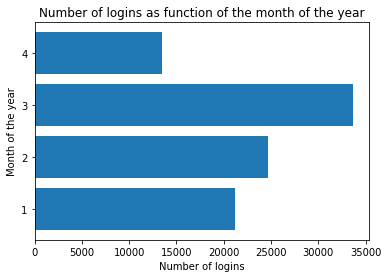

In [20]:
#Plot the month counts
plt.barh(y = df3_grouped.index, width = df3_grouped['Count'])
plt.xlabel('Number of logins')
plt.ylabel('Month of the year')
plt.title('Number of logins as function of the month of the year')
plt.yticks(np.arange(1,5))
plt.show()

#### Very similar counts regarding month, but with the 3rd month as the peak and the 4th month the lowest. There is not enough data to make conclusions about the behavior during all the year.

# Part 2

## Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
 
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

 a. how you will implement the experiment
 
 b. what statistical test(s) you will conduct to verify the significance of the
    observation
    
 c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

#### Before proposing the solutions, I would say that is necessary to make clear some points to the managers.

##### The first point is that it would be necessary to install a device that will have a record of the car who passes the bridge and the reimbursment would be give to the payment method on file. However, I would say is easier if the fee is just waived for the time the experiment last. An electronical device would be installed to count the number of cars in a precise way. 

##### Cars need to be counted in both ways. Cars entering from Gotham to Metropolis, and cars entering from Metropolis to Gotham.

##### Besides, it is necessary to have the record of the number of cars who passed the bridge before the experiment to have a comparison point

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure would be the number of cars crossing from Gotham to Metropolis and viceversa. Having more cars crossing would mean an increase of driver partners and more communication between the cities.

#### 2  Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

###### a. how you will implement the experiment

A practical experiment I would suggest is to counter the number of drive partners that passed the bridge daily from 00:00 (midnight) to 23:59. This could be done as mentioned before by either waiving the fee for a period of at least 4, or reimbursing the fee to the drive partnets. It should be at least 3 months to have at least some data to make conclusions. 

###### b. what statistical test(s) you will conduct to verify the significance of the observation

Firstly, I will develop my hypothesis.

 - For Gotham

HO: The average of driver partners passing the bridge from Gotham to Metropolis would increase because there is no expense for crossing the bridge.

 - For Metropolis
 
HO: The average of driver partners passing the bridge from Metropolis to Gotham would increase because there is no expense for crossing the bridge.

#### For Gotham

Firstly, I will need to take the mean of drivers passing from Gotham to Metropolis with the toll fee. This value would be used to either refute or not refute the null hypothesis for Gotham. 
Then, I would take the mean of the number of driver partnets who passed the bridge from Gotham to Metropolis, and I will compare to the value obtained with the toll fee. To see if this is significant, I would bootstrap the experiment to repeat this over and over again, and get all the means. 
Lastly, to calculate the p-value, I will calculate how many times we get a lower mean for the no toll fee than the mean of driver partners with the toll fee. If the p-value is less than 0.05, then we get a statistical significance and we can make the conclusion that it would increase the traffic from Gotham to Metropolis.

#### For Metropolis

We are making the same experiment, but from Metropolis to Gotham, instead.

###### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

After getting the p-value, we can conclude if the traffict between the two cities may increase or not. To be clear of our conclusions, both p-values need to be lower than 0.05 because if one p-value is higher than 0.05, by just charging a toll fee from one city to the other may change the behavior if we take the experiment the other way around. 

Now, if we got that one p-value is higher than 0.05 and the other one not, then we mainly need to do two experiments more. One by just charging the toll fee from Gotham to Metropolis and the other experiment would be by just charging the toll fee from Metropolis to Gotham. Then, we can make final recommendations, and see what would be the best for both cities.

# Part 3

## Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.


3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD'

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days aftersigning up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [21]:
# Read the data
with open('ultimate_data_challenge.json') as json_file:
    json_data = json.load(json_file)

In [22]:
# See how the data looks like
json_data

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 3,
  'signup_date': '2014-01-06',
  'avg_rating_of_driver': 4.3,
  'avg_surge': 1.0,
  'last_trip_date': '2014-01-07',
  'phone': 'iPhone',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 100.0,
  'avg_dist': 0.77,
  'avg_rating_by_driver': 5.0},
 {'city': "King's Landing",
  'trips_in_fir

In [23]:
df = pd.DataFrame(json_data)

In [24]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
# See info of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [26]:
# See the column types
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [27]:
# Convert to datetime columns signup_date and last_trip_date
df['signup_date'] = pd.to_datetime(df['signup_date'], format = '%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format = '%Y-%m-%d')

In [28]:
#Check for Null Values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [29]:
# Fill the null values
df['phone'] = df['phone'].fillna('Not Registered')
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].replace(to_replace = np.nan,
                                                                value = df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].replace(to_replace = np.nan,
                                                                value = df['avg_rating_by_driver'].mean())

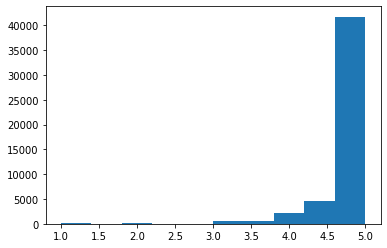

In [30]:
# See data distribution
plt.hist(df['avg_rating_by_driver'])
plt.show()

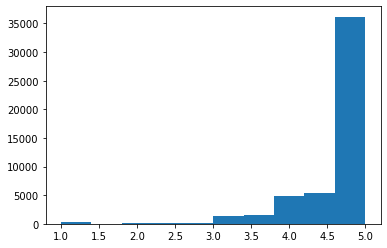

In [31]:
plt.hist(df['avg_rating_of_driver'])
plt.show()

#### From the plots we can see there is a tendency of having higher ratings. 

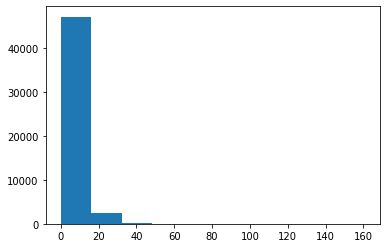

In [32]:
plt.hist(df['avg_dist'])
plt.show()

#### And trips are not characterized of being long

In [33]:
retrieve_data = df['last_trip_date'].min()
last_day = df['last_trip_date'].max()
active_user = last_day - pd.Timedelta('30 days')

In [34]:
last_day

Timestamp('2014-07-01 00:00:00')

In [35]:
#Create a new column that define when an user is active or not based on the condition
def active_column(df):
    if df['last_trip_date'] >= active_user:
        return 1
    else:
        return 0
    
df['Active User'] = df.apply(active_column, axis = 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active User
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [36]:
# We will also divide the city, phone, and ultimate_black_user into categorical features
df = pd.get_dummies(df)

In [37]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active User,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Not Registered,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


### To keep in mind
If city King's Landing and Winterfell are 0, then the city is Astapor
If phone is not registered and iphone are 0, then phone is Android

In [38]:
# See the counter of values to have a general idea of the percentage
df['Active User'].value_counts()

0    31196
1    18804
Name: Active User, dtype: int64

In [39]:
# Calculate the retention rate
num_active_user = sum(df['Active User'] == 1)
num_no_active = sum(df['Active User'] == 0)
retention_rate = num_active_user/(num_active_user + num_no_active)

In [40]:
# Calculating the retetion rate
print('The retention rate was {:.0%} approximately'.format(retention_rate))

The retention rate was 38% approximately


### Modeling

This is a classification problem where we need to create a model that will try to predict if an user is active or not, and additionally see what are the most important features.

In [41]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import GridSearchCV

#### Logistic Regression

In [42]:
# Divide into X and y arrays
X = df.drop(columns = {'Active User', 'signup_date', 'last_trip_date'}, axis = 1).values
y = df['Active User'].values

In [43]:
# Apply the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

We are going to use different methods and evaluate them. Depending on the accuracy, we are selecting a specific model.

In [44]:
# Establish the parameters grid to do the Grid Search CV
param_grid = {'tol': [0.0001, 0.001, 0.01, 0.1, 1.0],
             'C': [0.2, 0.4, 0.6, 0.8, 1.0]}

In [45]:
# Start the grid Search
log_reg = LogisticRegression()
log_reg_cv = GridSearchCV(log_reg, param_grid, cv = 3)
log_reg_cv.fit(X_train, y_train)
print('Best parameters: {}'.format(log_reg_cv.best_params_))
print('Best score: {}'.format(log_reg_cv.best_score_))

Best parameters: {'C': 0.2, 'tol': 0.01}
Best score: 0.71915


In [46]:
#Now, it is time to create the logistic regression with the best hyperparameters
reg = LogisticRegression(tol = 0.01, C = 0.2)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

In [47]:
# Creation of the confussion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [48]:
#Print confussion matrix
print(confusion_matrix(y_test, pred))

[[5332  886]
 [1941 1841]]


True Positive: 5332

True Negatives: 1841

False Positives: 886

False Negatives: 1941

In [49]:
#Calculate the accuracy of the model
true_positive_rate = 5332/(5332 + 1941)
true_negative_rate = 1841/(1841 + 886)
print('True Positive rate of accuracy is: {}'.format(true_positive_rate))
print('True Negative rate of accuracy is: {}'.format(true_negative_rate))

True Positive rate of accuracy is: 0.7331225079059536
True Negative rate of accuracy is: 0.6751008434176751


In [50]:
# Importance coefficient
features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'ultimate_black_user', 
            'weekday_pct', 'avg_dst', 'avg_rating_by_driver', 'Astapor', "King's Landing", 'Winterfell city', 'Android', 
           'Not registered Phone', 'iPhone']

In [51]:
# Feature Importance
df_importance = pd.DataFrame()
df_importance['Features'] = features
df_importance['Coefficient'] = reg.coef_.T

In [52]:
# Sort the values
df_importance.sort_values(by = 'Coefficient', ascending = False)

,Features,Coefficient
9,King's Landing,0.959124
4,ultimate_black_user,0.846910
13,iPhone,0.512254
0,trips_in_first_30_days,0.120122
3,surge_pct,0.003057
5,weekday_pct,0.000210
12,Not registered Phone,-0.007338
6,avg_dst,-0.036820
1,avg_rating_of_driver,-0.047714
2,avg_surge,-0.057582


It would be recommendable to check if there is a model with higher rate of accuracy.

#### Decision Tree

In [53]:
# Establish the hyperparameters to do the grid search
param_grid = {'criterion':['gini', 'entropy'], 'max_depth':[3,5,7,10,None], 'max_features':np.arange(1,15)}

In [54]:
# Grid Search application
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier_cv = GridSearchCV(tree_classifier, param_grid, cv = 3)
tree_classifier_cv.fit(X_train, y_train)
print('Best parameters: {}'.format(tree_classifier_cv.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 13}


In [55]:
# Fit the model witht the best parameters
tree_classifier = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 7, max_features = 7)
tree_classifier_fit = tree_classifier.fit(X_train, y_train)
pred = tree_classifier_fit.predict(X_test)

In [56]:
#Print confussion matrix
print(confusion_matrix(y_test, pred))

[[5237  981]
 [1357 2425]]


True Positive: 5206

True Negatives: 2420

False Positives: 1012

False Negatives: 1362

In [57]:
# Calculate the accuracy 
true_accuracy = 5206/(5206 + 1362)
false_accuracy = 2420/(2420 + 1012)
print('True Positive rate of accuracy is: {}'.format(true_accuracy))
print('True Negative rate of accuracy is: {}'.format(false_accuracy))

True Positive rate of accuracy is: 0.7926309378806333
True Negative rate of accuracy is: 0.7051282051282052


In [58]:
# Importances of each feature
importances = tree_classifier_fit.feature_importances_

In [59]:
# Feature Importance
df_importance = pd.DataFrame()
df_importance['Features'] = features
df_importance['Coefficient'] = importances

In [60]:
# Sorted Values
df_importance.sort_values(by = 'Coefficient', ascending = False)

,Features,Coefficient
7,avg_rating_by_driver,0.325188
9,King's Landing,0.180507
3,surge_pct,0.144074
5,weekday_pct,0.107753
13,iPhone,0.069320
4,ultimate_black_user,0.059995
11,Android,0.039140
0,trips_in_first_30_days,0.022964
2,avg_surge,0.020743
8,Astapor,0.012996


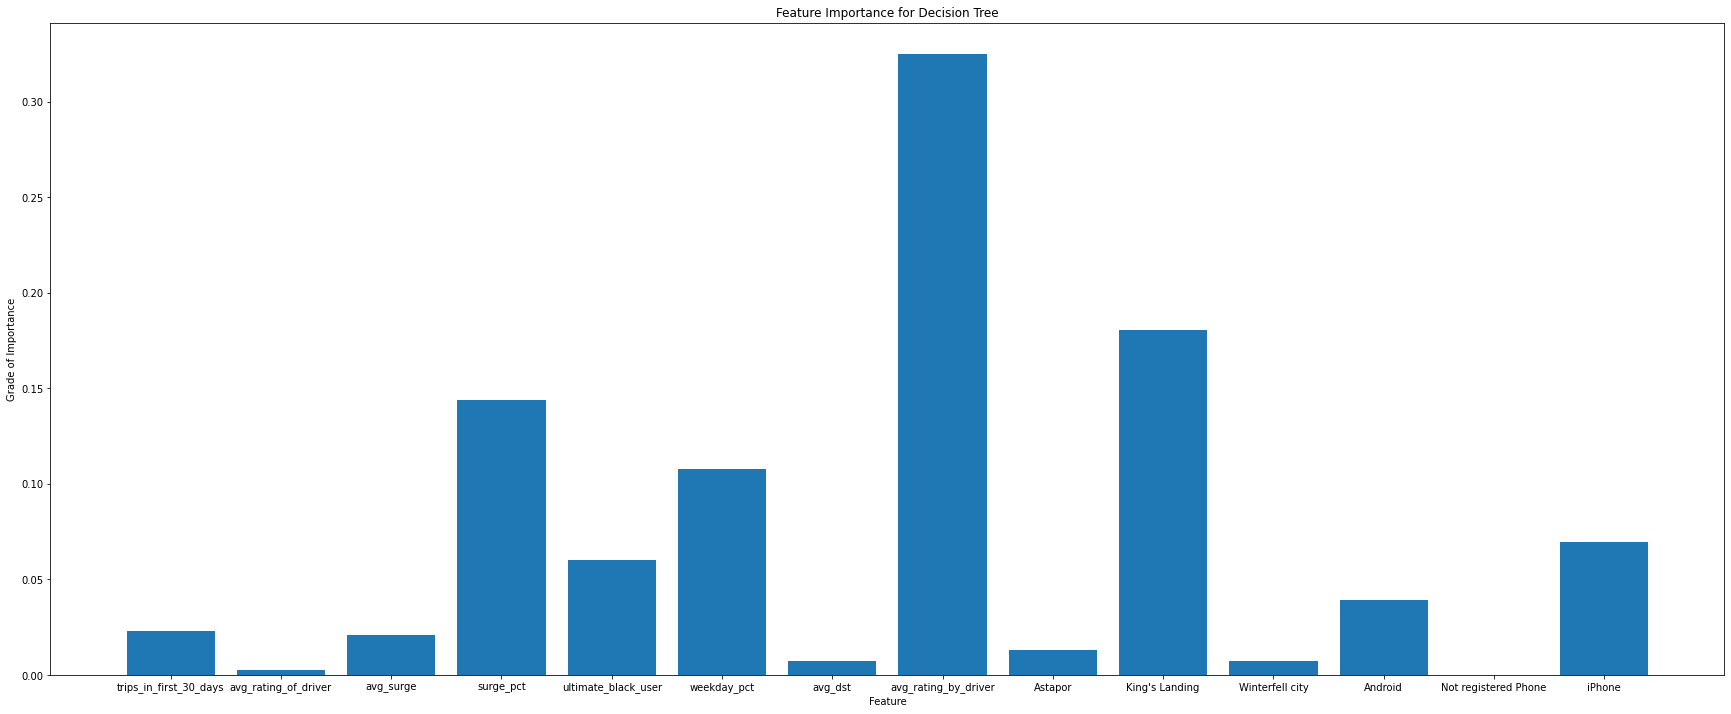

In [61]:
# Plot the results
plt.figure(figsize = (30,12))
plt.bar(x = df_importance['Features'], height = df_importance['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Grade of Importance')
plt.title('Feature Importance for Decision Tree')
plt.show()

#### Gradient Boosting Classifier

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
# Parameters grid to make the grid search vs
param_grid = {'learning_rate':[0.01, 0.1, 1.0],
             'n_estimators':[20,100],
             'max_depth':[3,5,7],
             'tol':[0.001, 0.1, 1.0]}

In [64]:
# Application of the grid search
gradient_classifier = GradientBoostingClassifier()
gradient_classifier_cv = GridSearchCV(gradient_classifier, param_grid, cv = 3)
gradient_classifier_cv.fit(X_train, y_train)
print('Best parameters: {}'.format(gradient_classifier_cv.best_params_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'tol': 0.1}


In [72]:
# Fit the model with the best hyperparameters
gradient_boosting = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 100, tol = 0.1)
gradient_boosting_fit = gradient_boosting.fit(X_train, y_train)
pred = gradient_boosting_fit.predict(X_test)

In [73]:
#Print confussion matrix
print(confusion_matrix(y_test, pred))

[[5363  855]
 [1275 2507]]


True Positive: 5363

True Negatives: 2507

False Positives: 855

False Negatives: 1275

In [74]:
#Calculate accuracy
true_accuracy = 5363/(5363+1275)
false_accuracy = 2507/(2507+855)
print('True Positive rate of accuracy is: {}'.format(true_accuracy))
print('True Negative rate of accuracy is: {}'.format(false_accuracy))

True Positive rate of accuracy is: 0.8079240735161193
True Negative rate of accuracy is: 0.7456870910172516


In [75]:
# Importances
importances = gradient_boosting_fit.feature_importances_

In [76]:
# Sorted Values
df_importance.sort_values(by = 'Coefficient', ascending = False)

,Features,Coefficient
7,avg_rating_by_driver,0.269863
3,surge_pct,0.152924
9,King's Landing,0.150608
5,weekday_pct,0.136558
4,ultimate_black_user,0.060450
11,Android,0.053939
0,trips_in_first_30_days,0.053690
6,avg_dst,0.039915
8,Astapor,0.025128
13,iPhone,0.024629


In [77]:
# Feature Importance
df_importance = pd.DataFrame()
df_importance['Features'] = features
df_importance['Coefficient'] = importances

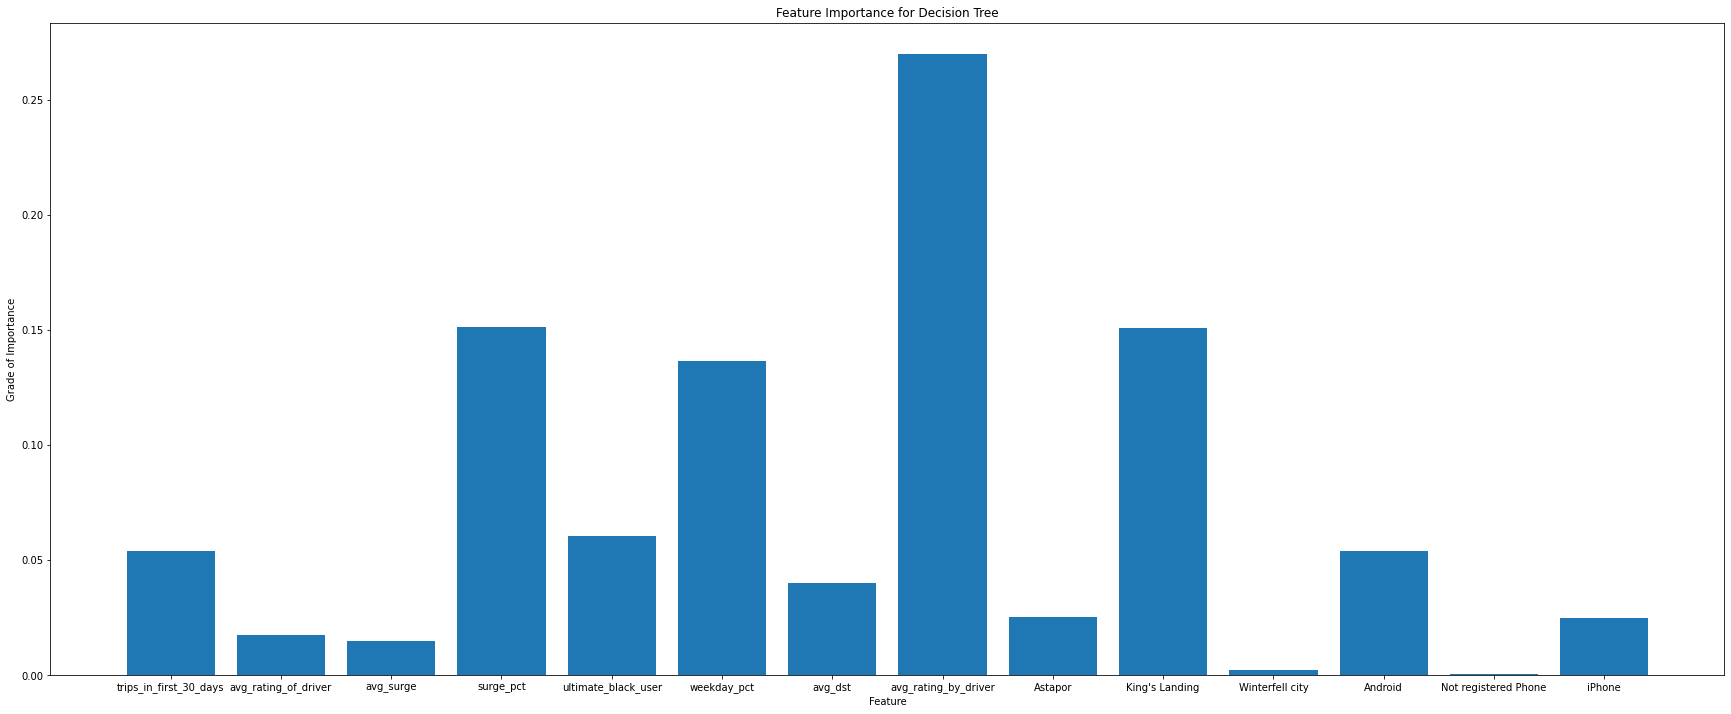

In [78]:
# Plot the importances of each feature
plt.figure(figsize = (30,12))
plt.bar(x = df_importance['Features'], height = df_importance['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Grade of Importance')
plt.title('Feature Importance for Decision Tree')
plt.show()

##### Insights

- From the models, we can conclude the feature that is more important is the average rating by the driver. Higher ratings by drivers would mean a better connection, and therefore a better service.


- From each model's result, I would go for the results obtained by applying the Gradient Boosting Classifier. It gets better results by predicting which would be an active customer and in addition which is not an active customer. The true accuracy result is similar between the Gradient Boosting and the Decision Tree, but the accuracy on the true negatives is higher on the Gradient Boosting, which make me feel this Gradient Boosting is more reliable. 


- King's Landing looks to be the city with more active users. There is a trend that this city would have more active users than the other two cities.


- Also an important feature that is important to analyze is the surge percentage and the weekday percentage to increase the retention rate.